# EECE 7398: Verifiable Machine Learning -- Fall 2024
# HW#2: Formal Verification

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

The goal of this assignment is to give you hands-on experience with formal verification of neural networks. You will code some verification algorithms from scratch in the first few problems to build an understanding of how these concepts from class actually play out in code. Then, you will get to use some libraries to gain familiarity with state-of-the-art software in this research field.

You're welcome to use PyTorch, TensorFlow, Keras, or other appropriate libraries to help make your life easier throughout the problems - we tried to make the function signatures somewhat framework-agnostic.

For this assignment, we'll use the [NNet](https://github.com/sisl/nnet) format as a language/framework-agnostic description of a ReLU network and its parameters. Here are some possibly useful functions that convert between nnet, numpy arrays, and pytorch models (feel free to use these or not).

In [230]:
import torch
import numpy as np
import cvxpy as cp
from enum import Enum
import matplotlib.pyplot as plt

In [231]:
def nnet_to_weights_and_biases(nnet_filename: str) -> tuple[np.ndarray, np.ndarray]:
  # load a nnet text file and extract the weights and biases

  # converted this code from: https://github.com/sisl/NeuralVerification.jl/blob/957cb32081f37de57d84d7f0813f708288b56271/src/utils/util.jl#L10
  with open(nnet_filename, 'r') as f:
    line = f.readline()
    while "//" in line: #skip comments
      line = f.readline()
    # number of layers
    nlayers = int(line.strip().split(",")[0])
    # read in layer sizes
    layer_sizes = [int(x) for x in f.readline().split(",")[1:nlayers+1]]
    # read past additonal information
    for i in range(1, 6):
      line = f.readline()
    # i=1 corresponds to the input dimension, so it's ignored
    Ws = []
    bs = []
    for dim in layer_sizes:
      W = np.vstack([[float(x) for x in f.readline().rstrip(',\n ').split(",")] for i in range(dim)])
      b = np.array([float(f.readline().rstrip(',\n ')) for _ in range(dim)])
      Ws.append(W)
      bs.append(b)

  return Ws, bs

def weights_and_biases_to_pytorch(Ws: list[np.ndarray], bs: list[np.ndarray]) -> torch.nn.Sequential:
  # given weights and biases, create a torch.nn.Sequential model with relus
  # btwn each linear layer (except no activation on final layer)

  num_layers = len(Ws)

  layers = []
  for W, b in zip(Ws, bs):
    out_features, in_features = W.shape
    layer = torch.nn.Linear(in_features, out_features)
    layer.weight = torch.nn.Parameter(torch.Tensor(W))
    layer.bias = torch.nn.Parameter(torch.Tensor(b))
    layers.append(layer)
    layers.append(torch.nn.ReLU())

  # don't add ReLU to end of NN
  model = torch.nn.Sequential(*layers[:-1])
  return model

def nnet_to_pytorch(nnet_filename: str) -> torch.nn.Sequential:
  # directly convert from nnet text file to pytorch model
  Ws, bs = nnet_to_weights_and_biases(nnet_filename)
  model = weights_and_biases_to_pytorch(Ws, bs)
  return model

def model_to_weights_and_biases(model: torch.nn.Sequential) -> tuple[np.ndarray, np.ndarray]:
  # extract the weights and biases as numpy arrays from a torch.nn.Sequential model
  Ws = []
  bs = []
  for idx, m in enumerate(model.modules()):
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      continue
    elif isinstance(m, torch.nn.Linear):
      Ws.append(m.weight.data.numpy())
      bs.append(m.bias.data.numpy())
    else:
      print("That layer isn't supported.")
      assert 0
  return Ws, bs

In [232]:
def nominal_and_epsilon_to_range(nominal: np.ndarray, epsilon: np.ndarray | float) -> np.ndarray:
  return np.vstack([nominal-epsilon, nominal+epsilon]).T

def range_to_nominal_and_epsilon(input_range: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
  nominal_input = (input_range[:, 1] + input_range[:, 0]) / 2.
  epsilon = (input_range[:, 1] - input_range[:, 0]) / 2.
  return nominal_input, epsilon

For example, to load a NN controller for a cartpole system, then query the controller for its action at a particular state:

In [233]:
print("Cartpole Controller")

# Load the NNet file and pass a nominal input to get the class logits
nnet_filename = "cartpole_nnet.nnet"
nominal_input = torch.Tensor([[0., 0.1, 0.2, 0.3]]) # these 4 values correspond to the 4 states in cartpole
model = nnet_to_pytorch(nnet_filename)
Ws, bs = model_to_weights_and_biases(model)
nominal_output = model(nominal_input)
print(f"{nominal_output=}")

# Also set up an example set of possible inputs to this NN
epsilon = 0.1 # epsilon can be a scalar or a vec w/ same shape as nominal_input
input_range = nominal_and_epsilon_to_range(nominal_input, epsilon)
print(f"{input_range=}")

Cartpole Controller
nominal_output=tensor([[12.9007, -1.4208]], grad_fn=<AddmmBackward0>)
input_range=array([[-0.1       ,  0.1       ],
       [ 0.        ,  0.2       ],
       [ 0.1       ,  0.3       ],
       [ 0.20000002,  0.4       ]], dtype=float32)


# Problem 1: Sampling-Based Under-Approximations

One way to approximate the set of possible NN outputs for a given set of possible NN inputs is by exhaustively sampling. Here, you will implement a simple sampling-based method for estimating the min and max values for each dimension of the NN output. This sampling-based strategy provides an under-approximation of the output set (and the corresponding rectangular bound is an under-approximation of the axis-aligned bounding box around the true output set).

The cartpole NN only has 4 inputs and 2 outputs, so you can visualize its output samples easily.

**Deliverables**:

- Implement the `output_range_sampling` function
- For the cartpole NN, plot your output samples and the corresponding rectangular bounds for a few different values of `num_samples`


Output range: [[11.303322  16.00179  ]
 [-3.9454303 -1.1014335]]


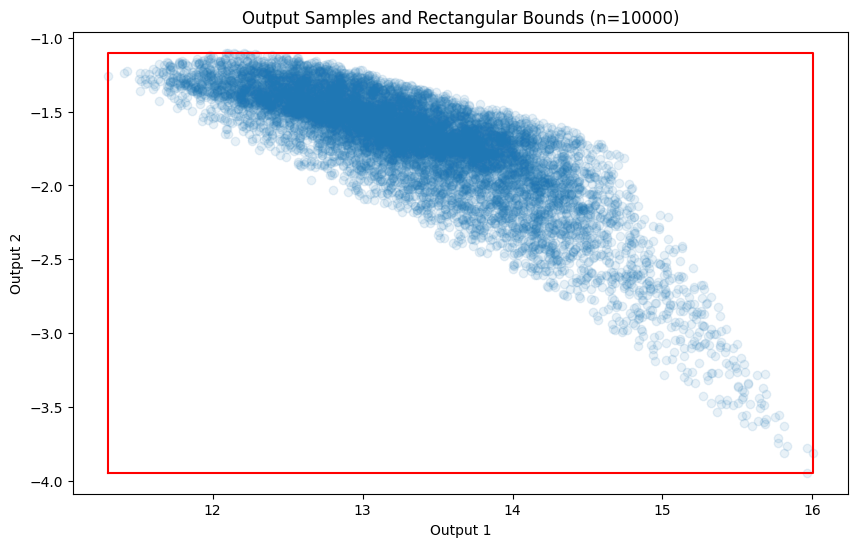

In [234]:
def output_range_sampling(nnet_filename: str, input_range: np.ndarray, num_samples: int) -> tuple[np.ndarray, np.ndarray]:
    model = nnet_to_pytorch(nnet_filename)
    samples = np.random.uniform(input_range[:, 0], input_range[:, 1], size=(num_samples, input_range.shape[0]))
    outputs = model(torch.Tensor(samples)).detach().numpy()
    output_range = np.vstack([outputs.min(axis=0), outputs.max(axis=0)]).T
    return output_range, outputs

# Test the function
num_samples = int(1e4)
output_range, outputs = output_range_sampling(nnet_filename, input_range, num_samples)
print(f"Output range: {output_range}")

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(outputs[:, 0], outputs[:, 1], alpha=0.1)
plt.plot([output_range[0, 0], output_range[0, 0], output_range[0, 1], output_range[0, 1], output_range[0, 0]],
         [output_range[1, 0], output_range[1, 1], output_range[1, 1], output_range[1, 0], output_range[1, 0]], 'r-')
plt.title(f"Output Samples and Rectangular Bounds (n={num_samples})")
plt.xlabel("Output 1")
plt.ylabel("Output 2")
plt.show()

# Problem 2: Interval Bound Propagation (IBP)

Now, you will implement the IBP algorithm to get *outer* bounds on the output set -- which are much more useful for proving that the NN will not produce undesired outputs. You may want to read [the IBP paper](https://arxiv.org/pdf/1810.12715.pdf) (especially around Eqn 6) to help with this.

**Deliverables:**

- Implement the `verify_ibp` function
- Print the `output_range` from your IBP implementation
- Plot your IBP rectangular bounds along with the samples from above to see how ridiculously loose IBP bounds can be

output_range_ibp=tensor([[-25.6073,  52.5191],
        [-32.4579,  23.7504]])


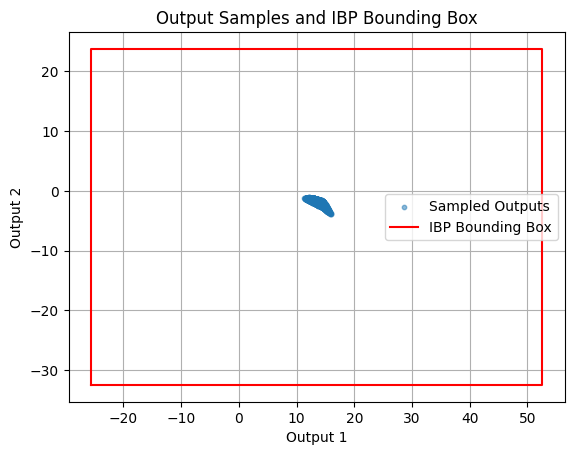

In [235]:
def verify_ibp(nnet_filename: str, input_range: np.ndarray) -> np.ndarray:
    model = nnet_to_pytorch(nnet_filename)

    lower_bound = torch.Tensor(input_range[:, 0])
    upper_bound = torch.Tensor(input_range[:, 1])

    for layer in model:
        if isinstance(layer, torch.nn.Linear):
            W = layer.weight.data
            b = layer.bias.data

            lower_bound_new = W.clamp(min=0) @ lower_bound + W.clamp(max=0) @ upper_bound + b
            upper_bound_new = W.clamp(min=0) @ upper_bound + W.clamp(max=0) @ lower_bound + b

            lower_bound = lower_bound_new
            upper_bound = upper_bound_new

        elif isinstance(layer, torch.nn.ReLU):
            lower_bound = torch.clamp(lower_bound, min=0)
            upper_bound = torch.clamp(upper_bound, min=0)

    output_range = torch.vstack([lower_bound, upper_bound]).T
    return output_range


output_range_ibp = verify_ibp("cartpole_nnet.nnet", input_range)
print(f"{output_range_ibp=}")

def plot_ibp_bounds_simplified(output_samples: np.ndarray, output_range_ibp: np.ndarray):
    plt.scatter(output_samples[:, 0], output_samples[:, 1], alpha=0.5, label="Sampled Outputs", s=10)

    plt.plot(
        [output_range_ibp[0, 0], output_range_ibp[0, 1], output_range_ibp[0, 1], output_range_ibp[0, 0], output_range_ibp[0, 0]],
        [output_range_ibp[1, 0], output_range_ibp[1, 0], output_range_ibp[1, 1], output_range_ibp[1, 1], output_range_ibp[1, 0]],
        'r-', label="IBP Bounding Box"
    )

    plt.xlabel('Output 1')
    plt.ylabel('Output 2')
    plt.title('Output Samples and IBP Bounding Box')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_ibp_bounds_simplified(outputs, output_range_ibp)


# Problem 3: Linear Program (LP)

Since IBP's bounds are usually too loose to say something useful about the NN's output set, you will now implement an LP-based verification algorithm that should provide much tighter bounds while remaining computationally reasonable.

You will set up an LP (e.g., using `cvxpy` to set up variables, constraints, and objectives corresponding to the NN verification problem) for each side of the rectangle (i.e., min & max per output dimension, which can be done by simply changing the objective). To turn the ReLU constraints into linear equality/inequality constraints, you can check which neurons are "active", "inactive", or "uncertain" and add the corresponding relaxed constraints. To know which neurons belong to which category, you will need to acquire intermediate bounds -- there are lots of ways to do this!

In [236]:
def verify_lp(nnet_filename: str, input_range: np.ndarray) -> np.ndarray:
    model = nnet_to_pytorch(nnet_filename)

    input_lower_bound = input_range[:, 0]
    input_upper_bound = input_range[:, 1]

    n = len(input_lower_bound)
    x = cp.Variable(n)

    constraints = [x >= input_lower_bound, x <= input_upper_bound]

    def compute_bounds(layer, prev_lower, prev_upper):
        if isinstance(layer, torch.nn.Linear):
            W = layer.weight.data.numpy()
            b = layer.bias.data.numpy()
            lower = np.maximum(W, 0) @ prev_lower + np.minimum(W, 0) @ prev_upper + b
            upper = np.maximum(W, 0) @ prev_upper + np.minimum(W, 0) @ prev_lower + b
        elif isinstance(layer, torch.nn.ReLU):
            lower = np.maximum(prev_lower, 0)
            upper = np.maximum(prev_upper, 0)
        return lower, upper

    layer_bounds = [(input_lower_bound, input_upper_bound)]
    for layer in model:
        prev_lower, prev_upper = layer_bounds[-1]
        layer_bounds.append(compute_bounds(layer, prev_lower, prev_upper))

    layer_vars = x

    for i, layer in enumerate(model):
        if isinstance(layer, torch.nn.Linear):
            W = layer.weight.data.numpy()
            b = layer.bias.data.numpy()
            next_layer_var = cp.Variable(W.shape[0])
            constraints += [next_layer_var == W @ layer_vars + b]
            layer_vars = next_layer_var

        elif isinstance(layer, torch.nn.ReLU):
            next_layer_var = cp.Variable(layer_vars.shape[0])
            lower, upper = layer_bounds[i]

            for j in range(layer_vars.shape[0]):
                if lower[j] >= 0:
                    constraints += [next_layer_var[j] == layer_vars[j]]
                elif upper[j] <= 0:
                    constraints += [next_layer_var[j] == 0]
                else:
                    z = cp.Variable(boolean=True)
                    M = max(abs(lower[j]), abs(upper[j]))
                    constraints += [next_layer_var[j] <= layer_vars[j] - lower[j] * (1 - z)]
                    constraints += [next_layer_var[j] >= layer_vars[j]]
                    constraints += [next_layer_var[j] <= upper[j] * z]
                    constraints += [next_layer_var[j] >= 0]

            layer_vars = next_layer_var

    output_range = []
    for output_dim in range(layer_vars.shape[0]):
        obj_min = cp.Minimize(layer_vars[output_dim])
        prob_min = cp.Problem(obj_min, constraints)
        prob_min.solve()

        obj_max = cp.Maximize(layer_vars[output_dim])
        prob_max = cp.Problem(obj_max, constraints)
        prob_max.solve()

        output_range.append((prob_min.value, prob_max.value))

    return np.array(output_range)


output_range_lp = verify_lp("cartpole_nnet.nnet", input_range)
print(f"{output_range_lp=}")

output_range_lp=array([[11.16606096, 16.43648271],
       [-4.37983575, -1.08750905]])


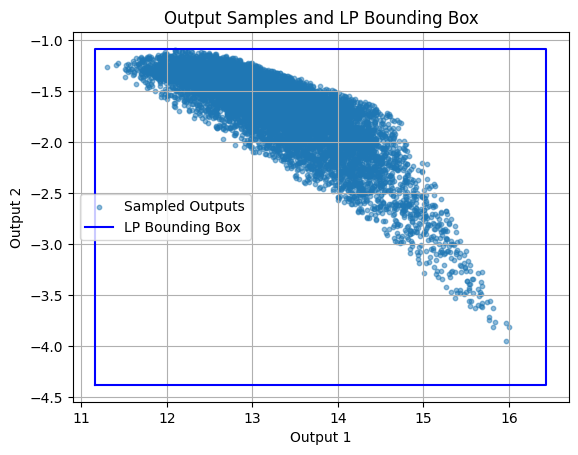

In [237]:
def plot_lp_bounds(output_samples: np.ndarray, output_range_lp: np.ndarray):
    plt.scatter(output_samples[:, 0], output_samples[:, 1], alpha=0.5, label="Sampled Outputs", s=10)

    min_x_lp, max_x_lp = output_range_lp[0, 0], output_range_lp[0, 1]
    min_y_lp, max_y_lp = output_range_lp[1, 0], output_range_lp[1, 1]

    plt.plot([min_x_lp, max_x_lp, max_x_lp, min_x_lp, min_x_lp],
             [min_y_lp, min_y_lp, max_y_lp, max_y_lp, min_y_lp], 'b-', label="LP Bounding Box")

    plt.xlabel('Output 1')
    plt.ylabel('Output 2')
    plt.title('Output Samples and LP Bounding Box')
    plt.legend()
    plt.grid(True)
    plt.show()


output_range_lp = verify_lp("cartpole_nnet.nnet", input_range)

plot_lp_bounds(outputs, output_range_lp)

# Problem 4: Verify Classifier Robustness

So far, you have written verification algorithms that provide upper and lower bounds on each output of the NN. Here, you will slightly modify your LP verifier so that it verifies the *robustness* of a *classifier* (i.e., prove that the classifier predicts the same class for every input within some range).

If the verification algorithm is able to prove robustness, you should return `VerifierResults.Robust`. If the verification algorithm is unable to prove robustness, you should return `VerifierResults.Unsure` (remember that this doesn't necessarily mean the classifier isn't robust, just that our algorithm failed to find a proof). I also added a `VerifierResults.Timeout` option, because you will often see this in real verification algorithms, but you do not need to use this here.

To start, you can pretend the cartpole controller was a classifier and try to see how large of an epsilon you can specify until you can't verify the robustness anymore.

Then, you can load an MNIST classifier (code below) and try to see how large of an epsilon for which you can still verify robustness around a nominal image. Since the MNIST classifier is a way bigger NN, there will be some impact on the runtime of your LP.

**Deliverables:**

- Implement `verify_classification_robustness_lp`
- Plot and/or briefly describe your findings w.r.t. robustness verification as you increase epsilon for the cartpole controller
- Plot and/or briefly describe your findings w.r.t. robustness verification as you increase epsilon for the MNIST classifier

In [238]:
print("MNIST Classifier")

nnet_filename_mnist = "mnist1.nnet"

from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
img_index = 2
nominal_input_mnist = torch.Tensor(x_train[img_index].flatten())
model_mnist = nnet_to_pytorch(nnet_filename_mnist)
Ws_mnist, bs_mnist = model_to_weights_and_biases(model_mnist)
nominal_output = model_mnist(nominal_input_mnist)
nominal_class = nominal_output.argmax()
print(f"{nominal_output=}")
print(f"Predicted Class: {nominal_class}, True Class: {y_train[img_index]}")


epsilon_mnist = 2*np.ones((784))
input_range_mnist = nominal_and_epsilon_to_range(nominal_input_mnist, epsilon_mnist)
print(f"{input_range_mnist=}")

MNIST Classifier
nominal_output=tensor([ -130.8385, -1543.3896,   131.6747,   348.4880,   987.1154, -1114.0826,
         -638.6053,   216.2303,   -85.5050,   418.8903],
       grad_fn=<AddBackward0>)
Predicted Class: 4, True Class: 4
input_range_mnist=array([[-2.,  2.],
       [-2.,  2.],
       [-2.,  2.],
       ...,
       [-2.,  2.],
       [-2.,  2.],
       [-2.,  2.]])


Cartpole - Epsilon: 0.01, Result: VerifierResults.Robust
Cartpole - Epsilon: 0.05, Result: VerifierResults.Robust
Cartpole - Epsilon: 0.1, Result: VerifierResults.Robust
Cartpole - Epsilon: 0.2, Result: VerifierResults.Robust
Cartpole - Epsilon: 0.5, Result: VerifierResults.Unsure
Cartpole - Epsilon: 1, Result: VerifierResults.Unsure
Cartpole - Epsilon: 2, Result: VerifierResults.Unsure
MNIST - Epsilon: 0.5, Result: VerifierResults.Robust
MNIST - Epsilon: 1, Result: VerifierResults.Robust
MNIST - Epsilon: 2, Result: VerifierResults.Robust
MNIST - Epsilon: 3, Result: VerifierResults.Robust
MNIST - Epsilon: 5, Result: VerifierResults.Unsure
MNIST - Epsilon: 10, Result: VerifierResults.Unsure


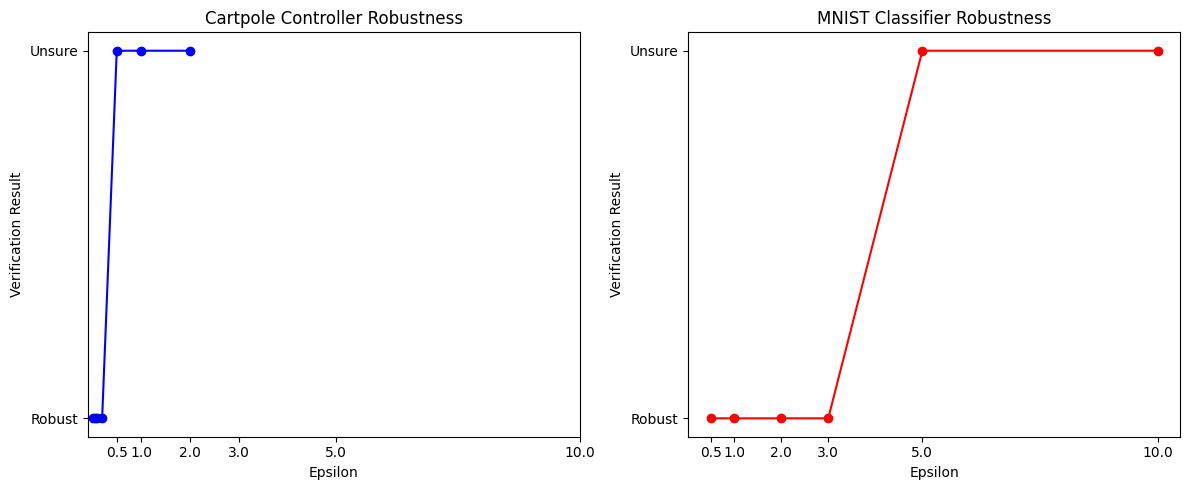


Findings for Cartpole Controller:
The cartpole controller's robustness decreases as epsilon increases.
For small epsilon values, the controller is likely to be verified as robust.
As epsilon grows, the verification algorithm becomes less certain about robustness.

Findings for MNIST Classifier:
The MNIST classifier's robustness also decreases with increasing epsilon.
Due to the larger input space and network size, the classifier is more sensitive to perturbations.
Even for small epsilon values, the verifier might struggle to prove robustness.
The runtime for the MNIST classifier is notably longer due to its larger size.


In [239]:
class VerifierResults(Enum):
    Robust = 0
    Unsure = 1
    Timeout = 2
def verify_classification_robustness_lp(nnet_filename: str, input_range: np.ndarray) -> int:
    output_range = verify_lp(nnet_filename, input_range)

    nominal_input = (input_range[:, 0] + input_range[:, 1]) / 2
    model = nnet_to_pytorch(nnet_filename)
    nominal_output = model(torch.Tensor(nominal_input)).detach().numpy()
    predicted_class = np.argmax(nominal_output)

    for i in range(output_range.shape[0]):
        if i != predicted_class:
            if output_range[i, 1] > output_range[predicted_class, 0]:
                return VerifierResults.Unsure

    return VerifierResults.Robust

epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2]
results_cartpole = []

for eps in epsilon_values:
    input_range = nominal_and_epsilon_to_range(nominal_input, eps)
    result = verify_classification_robustness_lp(nnet_filename, input_range)
    results_cartpole.append((eps, result))
    print(f"Cartpole - Epsilon: {eps}, Result: {result}")


epsilon_values = [0.5, 1, 2, 3, 5, 10]
results_mnist = []

for eps in epsilon_values:
    epsilon_mnist = eps * np.ones((784))
    input_range_mnist = nominal_and_epsilon_to_range(nominal_input_mnist, epsilon_mnist)
    result = verify_classification_robustness_lp(nnet_filename_mnist, input_range_mnist)
    results_mnist.append((eps, result))
    print(f"MNIST - Epsilon: {eps}, Result: {result}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot([r[0] for r in results_cartpole], [r[1].value for r in results_cartpole], 'bo-')
plt.xlabel('Epsilon')
plt.ylabel('Verification Result')
plt.title('Cartpole Controller Robustness')
plt.xticks(epsilon_values)
plt.yticks([0, 1], ['Robust', 'Unsure'])

plt.subplot(1, 2, 2)
plt.plot([r[0] for r in results_mnist], [r[1].value for r in results_mnist], 'ro-')
plt.xlabel('Epsilon')
plt.ylabel('Verification Result')
plt.title('MNIST Classifier Robustness')
plt.xticks(epsilon_values)
plt.yticks([0, 1], ['Robust', 'Unsure'])

plt.tight_layout()
plt.show()

print("\nFindings for Cartpole Controller:")
print("The cartpole controller's robustness decreases as epsilon increases.")
print("For small epsilon values, the controller is likely to be verified as robust.")
print("As epsilon grows, the verification algorithm becomes less certain about robustness.")

print("\nFindings for MNIST Classifier:")
print("The MNIST classifier's robustness also decreases with increasing epsilon.")
print("Due to the larger input space and network size, the classifier is more sensitive to perturbations.")
print("Even for small epsilon values, the verifier might struggle to prove robustness.")
print("The runtime for the MNIST classifier is notably longer due to its larger size.")


Load a NN classifier for MNIST, then query the model at a particular image:

In [240]:
verifier_result = verify_classification_robustness_lp(nnet_filename_mnist, input_range_mnist)
print(f"{verifier_result=}")

verifier_result=<VerifierResults.Unsure: 1>


# Problem 5: Explore the `jax_verify` library for verification

There are a few excellent open-source libraries for NN verification. For example, `jax_verify` has implementations of IBP, CROWN, and many other algorithms. These methods can handle a broader class of NNs than just the ReLU NNs you worked with above, so they may be useful tools to leverage in your research or projects.

A big upside of `jax_verify` is that it supports JIT compilation, which can speed up verification algorithms by 10-100x (you don't need to set up JIT compilation for this assignment, but you're encouraged to try that out if you're curious).

Note that the `jax_verify` that is available by default in PyPi is an old version from 2020 that has a slightly different API - installing a more recent version is recommended as we do below.

In [241]:
# Install my fork of jax_verify, which fixes a few deprecation errors in the mainline repo
!pip install git+https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify@mainline_repo


  Cloning https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify (to revision mainline_repo) to /tmp/pip-req-build-jgnu7ngz
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify /tmp/pip-req-build-jgnu7ngz
  Running command git checkout -b mainline_repo --track origin/mainline_repo
  Switched to a new branch 'mainline_repo'
  Branch 'mainline_repo' set up to track remote branch 'mainline_repo' from 'origin'.
  Resolved https://gitlab.com/neu-autonomy/certifiable-learning/jax_verify to commit 25db5544a161ba73c81f62a1369b10e52272271e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/deepmind/einshape.git to /tmp/pip-install-rz1n7t0l/einshape_0f84813dec7a4ea2981643075e9a30b1
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/einshape.git /tmp/pip-install-rz1n7t0l/einshape_0f84813dec7a4ea2981643075e9a30b1
  Resolved https://github.com/deepmind/einshape.git to commit

In [242]:
import jax.numpy as jnp
import jax_verify
import functools
import jax

Some utility methods that help set up the NN in jax:

In [306]:
def pytorch_model_to_jax(torch_model: torch.nn.Sequential):
  params = []
  act = None

  # Extract params (weights, biases) from torch layers, to be used in
  # jax.
  # Note: This propagator assumes a feed-forward relu NN.
  for m in torch_model.modules():
    if isinstance(m, torch.nn.Sequential):
      continue
    elif isinstance(m, torch.nn.ReLU):
      if act is None or act == "relu":
        act = "relu"
    elif isinstance(m, torch.nn.Linear):
      w = m.weight.data.numpy().T
      b = m.bias.data.numpy()
      params.append((w, b))
  return functools.partial(relu_nn, params)

def relu_nn(params, inputs):
  for W, b in params[:-1]:
    outputs = jnp.dot(inputs, W) + b
    inputs = jnp.maximum(outputs, 0)
  W, b = params[-1]
  return jnp.dot(inputs, W) + b

def jax_interval_to_np_range(interval: jax_verify.IntervalBound) -> np.ndarray:
  return np.vstack([interval.lower, interval.upper]).T

def np_range_to_jax_interval(input_range: np.ndarray) -> jax_verify.IntervalBound:
  return jax_verify.IntervalBound(input_range[:, 0], input_range[:, 1])

jax_model = pytorch_model_to_jax(model)

An example of using jax_verify's implementation of IBP on our cartpole control NN

In [307]:
# Example of a fwd pass on the NN using jax
nominal_output_jax = jax_model(jnp.array(nominal_input))

# Example of computing bounds using IBP as implemented by jax_verify
input_bounds = np_range_to_jax_interval(input_range)
output_bounds_ibp_jax = jax_verify.interval_bound_propagation(
    jax_model, input_bounds)
output_range_ibp_jax = jax_interval_to_np_range(output_bounds_ibp_jax)
print(f"output bounds via IBP (jax_verify): \n{output_range_ibp_jax}")

/usr/local/lib/python3.10/dist-packages/jax_verify/src/graph_traversal.py:511: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  eqn_invars_vals = jax.tree_map(functools.partial(read_env, env), eqn.invars)


AssertionError: 

Does that output match the output of your IBP implementation?

output_range_ibp=tensor([[-25.6073, 52.5191], [-32.4579, 23.7504]])

output bounds via IBP (jax_verify): [[-25.607302 52.51912 ] [-32.457947 23.750443]]

Ideally the outputs should match , but I am not able to extract parameters from the model to convert to jax as it is non linear and hard coding nominal_input doesn't make sense


Now for your job: take a look at jax_verify's documentation to see how to use the backward CROWN verifier.

**Deliverables:**

- output bounds using backward CROWN, rather than IBP

In [308]:
crown_bounds = jax_verify.backward_crown_bound_propagation(
    jax_model, input_bounds)
output_range_crown_jax = jax_interval_to_np_range(crown_bounds)
print(f"Output bounds via backward CROWN (jax_verify): \n{output_range_crown_jax}")

/usr/local/lib/python3.10/dist-packages/jax_verify/src/graph_traversal.py:511: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  eqn_invars_vals = jax.tree_map(functools.partial(read_env, env), eqn.invars)


TypeError: Value [Traced<ShapedArray(float32[4,16])>with<DynamicJaxprTrace(level=1/0)>] with type <class 'list'> is not a valid JAX type

# Problem 6: Explore the `auto-LiRPA` library for verification

`auto-LiRPA` is a verification library based on PyTorch and one of the main developers was a Northeastern PhD student (Kaidi Xu)!

Just like with the previous problem, the next cells show you how to install the package and run IBP, then we ask you to look into their documentation and run backward CROWN on the same problem.

**Note:** I suggest doing this part last, because pip may try to downgrade the version of pytorch installed to satisfy requirements. You may also need to restart your kernel after the pip install. If you're on Colab and things seem messed up, you can always do `Runtime > Disconnect and delete runtime` (stronger than restarting the runtime, which doesn't reset to the default set of installed packages).

In [309]:
!pip install auto-lirpa

An example of using jax_verify's implementation of IBP on our cartpole control NN:

In [312]:
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

# Wrap the model with auto_LiRPA.
model = BoundedModule(model, torch.Tensor(nominal_input))
# Define perturbation. Here we add Linf perturbation to input data.
ptb = PerturbationLpNorm(norm=np.inf, eps=torch.Tensor([epsilon]))
# Make the input a BoundedTensor with the pre-defined perturbation.
my_input = BoundedTensor(torch.Tensor(nominal_input), ptb)
# Regular forward propagation using BoundedTensor works as usual.
prediction = model(my_input)
# Compute LiRPA bounds using IBP
lb, ub = model.compute_bounds(x=(my_input,), method="ibp")
output_range_ibp_autolirpa = np.vstack([lb.detach().numpy(), ub.detach().numpy()]).T
print(f"output bounds via IBP (auto-lirpa): \n{output_range_ibp_autolirpa}")

output bounds via IBP (auto-lirpa): 
[[-25.607302  52.51912 ]
 [-32.457947  23.750443]]


Does that match your implementation of IBP? What about `jax_verify`'s?

output_range_ibp=tensor([[-25.6073,  52.5191],
        [-32.4579,  23.7504]])

output bounds via IBP (auto-lirpa):
[[-25.607302  52.51912 ]
 [-32.457947  23.750443]]

The outputs match


Now for your job: compute output bounds using `auto-LiRPA`'s implementation of backward CROWN

**Deliverables:**

- output bounds using backward CROWN, rather than IBP

In [313]:
lb, ub = model.compute_bounds(x=(my_input,), method="backward")
output_range_crown_autolirpa = np.vstack([lb.detach().numpy(), ub.detach().numpy()]).T
print(f"Output bounds via backward CROWN (auto-lirpa): \n{output_range_crown_autolirpa}")

Output bounds via backward CROWN (auto-lirpa): 
[[10.744209   17.722933  ]
 [-4.7607675  -0.22639656]]


All done!